<table><tr>
<td><img src="notebook_images/NORMAL2-IM-1423-0001.jpeg" style="width:320px;height:330px"/></td>
<td><img src= "notebook_images/person1945_bacteria_4872.jpeg" style="width:320px;height:330px"/></td>
<td><img src= "notebook_images/person36_bacteria_185.jpeg" style="width:320px;height:330px"/></td> 
</tr></table>

# Diagnosing Pneumonia Using CNNs
___
**Author:** Evan Holder<br>
Flatiron Data Science -Phase 4 

**[GitHub Link](https://github.com/EvanHolder/Pneuomonia-Classifier)**<br>
**[Presentation Link](https://drive.google.com/file/d/1gBzbuWmz_wfz1uRq4lgYccAxKlsjbMGd/view?usp=sharing)**

## Introduction and Overview
___
Pneumonia is a lung infection that affects people of all ages with varying degrees of severity. In fact, the [CDC](https://www.cdc.gov/dotw/pneumonia/index.html) reports that in 2018 about 1.5 million people were diagnosed with pneumonia and more than 40,000 of those people died. For children, pneumonia is the most infectious cause of death worldwide. In 2019, 740,180 children under the age of 5 died of pneumonia according to the [WHO](https://www.who.int/news-room/fact-sheets/detail/pneumonia).  While pneumonia is prevalent and deadly in populations across the world, its also treatable with the proper diagnosis.  For this reason, it's important that the infection is correctly identified so that it can be treated with low-cost and low-tech medication.  

## Business Problem
___
While pneumonia is diagnosable with symptoms and clinical features, chest x-rays remain the ["gold standard"](https://pneumonia.biomedcentral.com/articles/10.15172/pneu.2014.5/464) for confirming diagnosis of the infection.  Not only are x-rays widely available, but they're also relatively inexpensive and can be reviewed remotely.  With the advent of machine learning, it is possible to further decrease the cost of pneumonia diagnosis through identification of a pneumonia infection by way of convolutional neural networks.  Hospitals or general practices could administer X-rays and subsequently feed the images into a trained CNN to identify pneumonia without the need for a trained physician and/or simply use it to support a diagnosis. Once in use, this CNN would help lower the cost for both healthcare providers and patients themselves.


## Data Understanding
___
The data for this model comes from the [Kaggle dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) which originates from [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2).  X-rays are grayscale image data, so our model will be limitied to training on a single channel.

In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from keras import layers, models, regularizers
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.applications import Xception
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc, 
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)

import PIL
import os
import cv2 as cv
import math
import winsound

Here I'll just set up an alarm.  Since it takes variable amounts of time to complete a model, I'll want some notification that training is complete so that I can check the results of the models without wasting a lot time.

In [2]:
# Set up alarm for notification of model completion
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

Now, lets identify the directory paths that contain the data we'll be using.  After that I'll explore how much data we have.

In [6]:
# Identify data directories
data_train ='chest_xray/train'
data_test = 'chest_xray/test'
data_val = 'chest_xray/val'

In [3]:
# Get the files in each directory
train_norm =  [file for file in os.listdir('chest_xray/train/NORMAL') if file.endswith('jpeg')]
train_pneum =  [file for file in os.listdir('chest_xray/train/PNEUMONIA') if file.endswith('jpeg')]
test_norm =  [file for file in os.listdir('chest_xray/test/NORMAL') if file.endswith('jpeg')]
test_pneum =  [file for file in os.listdir('chest_xray/test/PNEUMONIA') if file.endswith('jpeg')]
val_norm =  [file for file in os.listdir('chest_xray/val/NORMAL') if file.endswith('jpeg')]
val_pneum =  [file for file in os.listdir('chest_xray/val/PNEUMONIA') if file.endswith('jpeg')]

# Print amount of data in each directory
tot = len(train_norm) + len(train_pneum) +len(test_norm) + len(test_pneum) + len(val_norm) + len(val_pneum)
print('Number of train images (normal):', len(train_norm))
print('Number of train images (pneumonia):', len(train_pneum))
print('Percentage of train images:', round((len(train_pneum)+ len(train_norm))/ tot, 3))

print('Number of validation images (normal):', len(val_norm))
print('Number of validation images (pneumonia):', len(val_pneum))
print('Percentage of val images:', round((len(val_pneum)+ len(val_norm))/ tot,3))

print('Number of test images (normal):', len(test_norm))
print('Number of test images (pneumonia):', len(test_pneum))
print('Percentage of test images:', round((len(test_pneum)+ len(test_norm))/ tot,3))

Number of train images (normal): 1341
Number of train images (pneumonia): 3875
Percentage of train images: 0.891
Number of test images (normal): 234
Number of test images (pneumonia): 390
Percentage of test images: 0.107
Number of validation images (normal): 8
Number of validation images (pneumonia): 8
Percentage of val images: 0.003


Only 16 images are included in the validation data. That's really not enough images to confidently evaluate the model and tweak accordingly.  Instead, we'll split the data into 75% training, 15% testing, and 15% validation. The test set is the holdout set to be used for evaluation of the final model.

Next, I'll move 1116 images (558 normal, 558 pneumonia) from training set into the validation and testing sets to create the 75-15-15 percent splits. That would be 254 images to the testing set, and 862 images to the validation set.

In [4]:
# Get first 127 images of training_normal and training pneumonia
train_normal_127 = train_norm[:127]
train_pneumonia_127 = train_pneum[:127]
train_normal_431 = train_norm[127:558]
train_pneumonia_431 = train_pneum[127:558]

# Move these image from their testing folders to the respective validation folders
for file in train_normal_127:
    os.replace(f'chest_xray/train/NORMAL/{file}', f'chest_xray/test/NORMAL/{file}')
for file in train_pneumonia_127:
    os.replace(f'chest_xray/train/PNEUMONIA/{file}', f'chest_xray/test/PNEUMONIA/{file}'
for file in train_normal_431:
    os.replace(f'chest_xray/train/NORMAL/{file}', f'chest_xray/val/NORMAL/{file}'))
for file in train_pneumonia_431:
    os.replace(f'chest_xray/train/PNEUMONIA/{file}', f'chest_xray/val/PNEUMONIA/{file}')

Below, I'll check that we moved the images to the correct folders and print the new portions of images in each set.

In [12]:
train_norm =  [file for file in os.listdir('chest_xray/train/NORMAL') if file.endswith('jpeg')]
train_pneum =  [file for file in os.listdir('chest_xray/train/PNEUMONIA') if file.endswith('jpeg')]
test_norm =  [file for file in os.listdir('chest_xray/test/NORMAL') if file.endswith('jpeg')]
test_pneum =  [file for file in os.listdir('chest_xray/test/PNEUMONIA') if file.endswith('jpeg')]
val_norm =  [file for file in os.listdir('chest_xray/val/NORMAL') if file.endswith('jpeg')]
val_pneum =  [file for file in os.listdir('chest_xray/val/PNEUMONIA') if file.endswith('jpeg')]
tot = len(train_norm) + len(train_pneum) +len(test_norm) + len(test_pneum) + len(val_norm) + len(val_pneum)

print('Number of train images (normal):', len(train_norm))
print('Number of train images (pneumonia):', len(train_pneum))
print('Percentage of train images:', round((len(train_pneum)+ len(train_norm))/ tot, 3))


print('Number of val images (normal):', len(val_norm))
print('Number of val images (pneumonia):', len(val_pneum))
print('Percentage of val images:', round((len(val_pneum)+ len(val_norm))/ tot,3))


print('Number of test images (normal):', len(test_norm))
print('Number of test images (pneumonia):', len(test_pneum))
print('Percentage of test images:', round((len(test_pneum)+ len(test_norm))/ tot,3))

Number of train images (normal): 783
Number of train images (pneumonia): 3317
Percentage of train images: 0.7
Number of val images (normal): 361
Number of val images (pneumonia): 517
Percentage of val images: 0.15
Number of test images (normal): 439
Number of test images (pneumonia): 439
Percentage of test images: 0.15


Next, let's check the class balance for each data set:

In [228]:
train_pneum_num = len(train_pneum)
val_pneum_num = len(val_pneum)
test_pnem_num = len(test_pneum)
train_norm_num = len(train_norm)
val_norm_num = len(val_norm)
test_norm_num = len(test_norm)

print('Training Class Balance:', round(train_pneum_num/(train_pneum_num+train_norm_num), 3))
print('Val Class Balance:', round(val_pneum_num/(val_pneum_num+val_norm_num),3))
print('Test Class Balance:', round(test_pnem_num/(test_pnem_num+test_norm_num),3))

Training Class Balance: 0.809
Val Class Balance: 0.589
Test Class Balance: 0.5


The training data contains more pneumonia images that normal images.  Both the testing and validation data have closer to 50% class balances.  For training, an 80% pneumonia images means our NN will learn patterns for pneumonia better than for normal x-rays.  The chance that the model classifies as pneumonia will be higher than that of normal, but this is okay.  In healthcare, we would rather ID the patient as having pneumonia and treating them for pneumonia even though they did not have. There is less harm in a false positive than a false negative. In the opposite case, the patient would have pneumonia but would receive no care because the model classified them as normal.

Next lets display one image just to see what it looks like.

Image Size: (1312, 960)


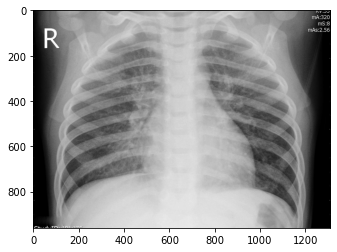

In [6]:
image = PIL.Image.open(f"chest_xray/train/PNEUMONIA/{train_pneum[0]}")
plt.imshow(image, cmap='gray');

# Get the size of the image
print('Image Size:', image.size)

From the above picture its, important to make two notes.  First, the picture is in grayscale. That means our neural networks should be set up for three dimensional tensors (length, width, depth=1). If these images were color we would need a depth=3 for red, green, blue color maps.  Second, the images are large (1312, 960) which means as we increase the complexity of the CNN, the number of trainable parameters will get unwieldy large quickly.  When loading in each image, they should be downsized appropriately so that we can actually train a CNN with the resources on hand.  Downsizing will also prevent the model from following random noise and overfitting to the training set.
## Helper Functions
___
As we iterate on through models, need a few functions to help us improve on the model.

`visualize_training_results()` - Logs the history of each model and plot it with a line plot

In [22]:
def visualize_training_results(history):
    '''
    Plot training and validation loss and accuracy for each model in a line plot
    
    PARAMETERS
    ----------
    history - history object containing model history
    '''
    history=history.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

`add_results()` - Given the model for which to evaluate, this function will calculate performance metrics and add them to a dataframe

In [64]:
def add_results(model, name, val_gen):
    '''
    Add model precision, recall, accuracy, and f1-score to results dataframe.
    
    PARAMETERS
    ----------
    model - trained keras model
    name - string, name of the model
    '''
    preds = model.predict(val_gen)
    preds[preds>=.5]=1
    preds[preds<.5]=0
    precision = round(precision_score(val_gen.labels, preds),2)
    recall = round(recall_score(val_gen.labels, preds), 2)
    f1 = round(f1_score(val_gen.labels, preds),2)
    accuracy = accuracy_score(val_gen.labels, preds)
    results.loc[name, ['precision', 'recall', 'f1', 'accuracy']] = [precision, recall, f1, accuracy]

`train_model()` - function we'll call to actually train the model since there are few things we'll want to keep the same each time we run it.
* Checkpoints - We'll make a checkpoint using keras callbacks.  This checkpoint will check the accuracy of the model after each epoch and save the weights if the accuracy is better than all other epochs so far.  Using this checkpoint we'll be able to save the weights of the model that give the best accuracy and minimize our chance of overfitting on the training data.
* Compile - We'll compile the model in the same way each time, except include parameters so that we can change the loss and optimizers if desired.
* Fit - We'll call the fit method to fit the model on the training data and run the val data through validation_data parameter
* After the model is finished training, well reload the weights of the best epoch of training and save the model
* Visualize the training results - call our new `visualize_training_results()` function
* Print the classification report, and add the performance metrics to the results df

<u>Note:</u> The evaluation metric was included as changeable parameter. For this project I'll use accuracy throughout the entirety of the modeling process. I would like to keep our evaluation metric consistent so that models are comparable. Accuracy is the metric of choice because the goal is binary classification and we would like to maximize the number of correctly identifiied pneumonia patients.

In [151]:
def train_model(name, model, loss, optimizer, train_gen, val_gen, metric, epochs):
    '''
    Train a model, visualize the results, and save the model.
    
    PARAMETERS
    ----------
    name - string, name of the model
    model - keras model, the model itself
    loss - string, loss function
    optimizer - string, optimizer for model compiling
    train_gen - ImageDataGenerator, training data
    val_gen - ImageDataGenerator, validation data
    metric - string, metric to evaluate model on
    epochs - int, number of epochs to train model for
    
    RETURNS
    -------
    Trained keras model
    '''
    # Create early stopping point
    stop = keras.callbacks.EarlyStopping(monitor='val_acc',
                                         patience=10,
                                         restore_best_weights=True)
    
    # Compile the model
    model.compile(loss=loss, 
                   optimizer=optimizer,
                   metrics=['acc'])
    
    # Fit the model
    history = model.fit(train_gen,
                        validation_data=val_gen,
                        epochs=epochs,
                        callbacks=[stop])
    
    # Save the model
    model.save(f'models/{name}')
    
    # Delete contents in checkpoints folder
    for file in os.listdir('checkpoints/'):
        os.remove(f'checkpoints/{file}')
        
    # Visualize training results
    visualize_training_results(history)
    
    # Print Classification report
    preds = model.predict(val_gen)
    preds[preds>=.5]=1
    preds[preds<.5]=0
    print(classification_report(val_gen.labels, preds, target_names=['normal', 'pneumonia']))
        
    # Add performance metrics to the results df
    add_results(model, name, val_gen)
    
    # Beep to notify end of training
    winsound.Beep(freq, duration)
    return model

Lastly, we'll need to instantiate the results dataframe and create a folder for our model checkpoints to save.

In [105]:
# Create results dataframe
results = pd.DataFrame(columns=['precision', 'recall', 'f1', 'accuracy'])

# Create checkpoints folder to log model weights
os.mkdir('checkpoints')

## Modeling
___

**$M_0$ - Baseline Model**

Here we'll set up the initial baseline architecture.
* Conv2D layers: 16-32-64 
* Dense layers: 100-1

In [113]:
# get all the data in the directory split/test, and reshape them
size = (64, 64)
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


In [114]:
model = keras.models.load_model('models/model_0')
add_results(model, 'model_0', val_gen)

Epoch 1/100
205/205 [==============================] - 42s 202ms/step - loss: 0.8947 - acc: 0.8090 - val_loss: 0.8576 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 41s 199ms/step - loss: 0.3819 - acc: 0.8090 - val_loss: 0.5471 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 40s 194ms/step - loss: 0.2734 - acc: 0.8076 - val_loss: 0.4408 - val_acc: 0.8280
Epoch 4/100
205/205 [==============================] - 43s 207ms/step - loss: 0.2436 - acc: 0.9207 - val_loss: 0.5595 - val_acc: 0.7563
Epoch 5/100
205/205 [==============================] - 44s 214ms/step - loss: 0.2115 - acc: 0.9395 - val_loss: 0.7008 - val_acc: 0.5888
Epoch 6/100
205/205 [==============================] - 44s 213ms/step - loss: 0.1986 - acc: 0.9349 - val_loss: 0.4253 - val_acc: 0.8599
Epoch 7/100
205/205 [==============================] - 40s 195ms/step - loss: 0.2045 - acc: 0.9456 - val_loss: 0.6579 - val_acc: 0.7392
Epoch 8/100
205/205 [===========================

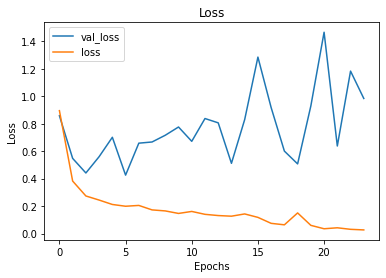

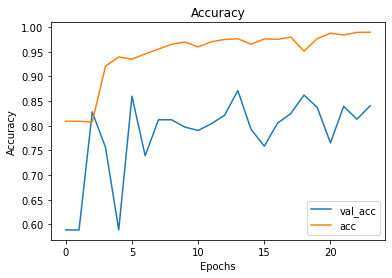

              precision    recall  f1-score   support

      normal       0.93      0.74      0.83       361
   pneumonia       0.84      0.96      0.90       517

    accuracy                           0.87       878
   macro avg       0.89      0.85      0.86       878
weighted avg       0.88      0.87      0.87       878



In [13]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(64,64, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', input_shape=(64,64, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', input_shape=(64,64, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_0',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u>
The intial model performed fairly well on our val data with ~87% accuracy.  The model is a bit overfit to the training data as the training/val accuracies differ by about 10%.

**$M_1$ - Change optimizer to RMSprop**

Epoch 1/100
205/205 [==============================] - 52s 240ms/step - loss: 0.1278 - acc: 0.9712 - val_loss: 1.0704 - val_acc: 0.7836
Epoch 2/100
205/205 [==============================] - 46s 224ms/step - loss: 0.0854 - acc: 0.9727 - val_loss: 0.6845 - val_acc: 0.8554
Epoch 3/100
205/205 [==============================] - 46s 223ms/step - loss: 0.0655 - acc: 0.9795 - val_loss: 1.3700 - val_acc: 0.7882
Epoch 4/100
205/205 [==============================] - 50s 245ms/step - loss: 0.0681 - acc: 0.9776 - val_loss: 0.9033 - val_acc: 0.8360
Epoch 5/100
205/205 [==============================] - 51s 249ms/step - loss: 0.0553 - acc: 0.9776 - val_loss: 0.8741 - val_acc: 0.8440
Epoch 6/100
205/205 [==============================] - 47s 230ms/step - loss: 0.0557 - acc: 0.9802 - val_loss: 1.0947 - val_acc: 0.8200
Epoch 7/100
205/205 [==============================] - 45s 220ms/step - loss: 0.0468 - acc: 0.9827 - val_loss: 0.9434 - val_acc: 0.8371
Epoch 8/100
205/205 [===========================

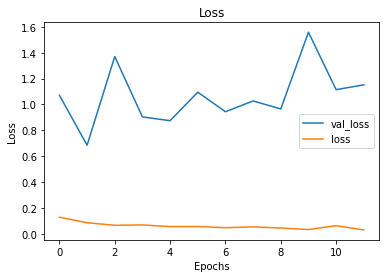

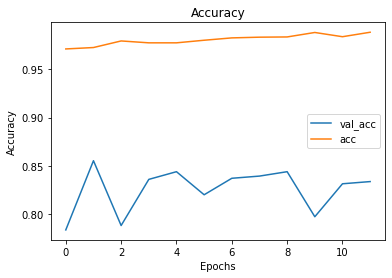

              precision    recall  f1-score   support

      normal       0.95      0.69      0.80       361
   pneumonia       0.82      0.97      0.89       517

    accuracy                           0.86       878
   macro avg       0.88      0.83      0.84       878
weighted avg       0.87      0.86      0.85       878



In [14]:
model = train_model(name='model_1',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.RMSprop(), 
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> Using the RMSprop optimizer did change the performance of the model significantly. Lets go back to the adam optimizer.  For $M_2$, lets add L2 regularizers to fix our overfitting issue.

**$M_2$ - Change back to the adam optimizer, add L2 regularization.**

Epoch 1/100
205/205 [==============================] - 48s 231ms/step - loss: 1.0871 - acc: 0.8090 - val_loss: 0.8976 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 47s 230ms/step - loss: 0.6214 - acc: 0.8090 - val_loss: 0.8034 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 60s 293ms/step - loss: 0.5743 - acc: 0.8090 - val_loss: 0.8034 - val_acc: 0.5888
Epoch 4/100
205/205 [==============================] - 47s 226ms/step - loss: 0.5428 - acc: 0.8090 - val_loss: 0.9956 - val_acc: 0.5888
Epoch 5/100
205/205 [==============================] - 45s 222ms/step - loss: 0.5302 - acc: 0.8090 - val_loss: 0.8319 - val_acc: 0.5888
Epoch 6/100
205/205 [==============================] - 52s 254ms/step - loss: 0.5241 - acc: 0.8090 - val_loss: 0.8350 - val_acc: 0.5888
Epoch 7/100
205/205 [==============================] - 50s 244ms/step - loss: 0.5218 - acc: 0.8090 - val_loss: 0.7890 - val_acc: 0.5888
Epoch 8/100
205/205 [===========================

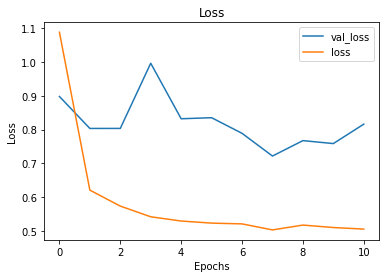

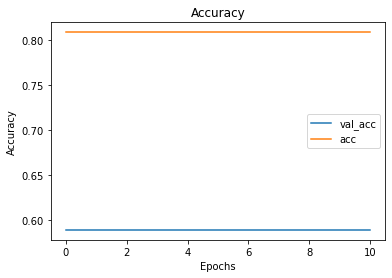

C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       361
   pneumonia       0.59      1.00      0.74       517

    accuracy                           0.59       878
   macro avg       0.29      0.50      0.37       878
weighted avg       0.35      0.59      0.44       878



In [28]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(64,64, 1), 
                        kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_2',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> $M_2$ appears to be over-regularized as the model did not improve at all through training. Let's decrease L2 from 0.01 to 0.0001

**$M_3$ - Modify regularization by decreasing L2 to 0.0001**

Epoch 1/100
205/205 [==============================] - 50s 241ms/step - loss: 0.6482 - acc: 0.8090 - val_loss: 0.7524 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 56s 276ms/step - loss: 0.4272 - acc: 0.8090 - val_loss: 0.7232 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 49s 241ms/step - loss: 0.2842 - acc: 0.8085 - val_loss: 0.7437 - val_acc: 0.5888
Epoch 4/100
205/205 [==============================] - 51s 248ms/step - loss: 0.2551 - acc: 0.8902 - val_loss: 0.4835 - val_acc: 0.8007
Epoch 5/100
205/205 [==============================] - 46s 226ms/step - loss: 0.2209 - acc: 0.9402 - val_loss: 0.5604 - val_acc: 0.8109
Epoch 6/100
205/205 [==============================] - 45s 219ms/step - loss: 0.2117 - acc: 0.9439 - val_loss: 0.7726 - val_acc: 0.7517
Epoch 7/100
205/205 [==============================] - 46s 226ms/step - loss: 0.1971 - acc: 0.9556 - val_loss: 0.4687 - val_acc: 0.8554
Epoch 8/100
205/205 [===========================

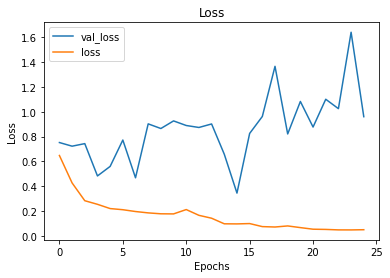

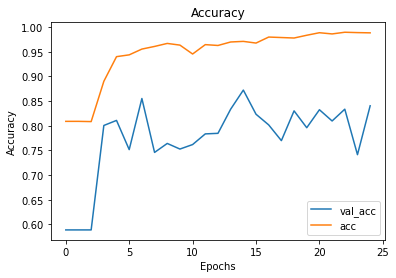

              precision    recall  f1-score   support

      normal       0.91      0.77      0.83       361
   pneumonia       0.85      0.95      0.90       517

    accuracy                           0.87       878
   macro avg       0.88      0.86      0.86       878
weighted avg       0.88      0.87      0.87       878



In [29]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(64,64, 1), 
                        kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_3',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> $M_3$ is still overfitting and did not seem to improve the accuracy at all. Let's try changing up the architecture a bit by increasing the number of nodes in our dense layer to 512.

**$M_4$ - Increase Dense layer nodes from 100 to 512**

Epoch 1/100
205/205 [==============================] - 47s 227ms/step - loss: 0.8149 - acc: 0.8044 - val_loss: 0.7418 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 46s 223ms/step - loss: 0.6441 - acc: 0.8090 - val_loss: 0.6465 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 48s 233ms/step - loss: 0.3310 - acc: 0.8629 - val_loss: 0.8652 - val_acc: 0.6754
Epoch 4/100
205/205 [==============================] - 55s 268ms/step - loss: 0.2094 - acc: 0.9244 - val_loss: 0.4510 - val_acc: 0.8132
Epoch 5/100
205/205 [==============================] - 52s 252ms/step - loss: 0.1560 - acc: 0.9361 - val_loss: 0.5354 - val_acc: 0.7995
Epoch 6/100
205/205 [==============================] - 48s 233ms/step - loss: 0.1208 - acc: 0.9522 - val_loss: 0.7748 - val_acc: 0.7665
Epoch 7/100
205/205 [==============================] - 47s 228ms/step - loss: 0.1105 - acc: 0.9544 - val_loss: 0.7492 - val_acc: 0.7608
Epoch 8/100
205/205 [===========================

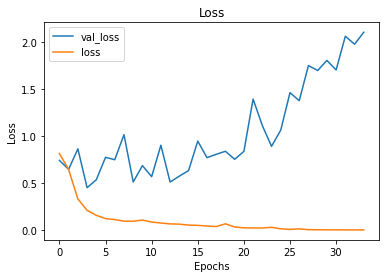

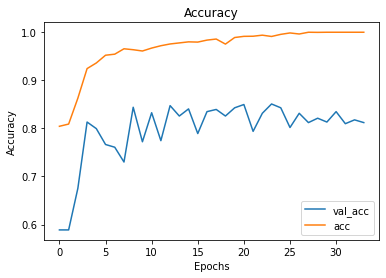

              precision    recall  f1-score   support

      normal       0.96      0.66      0.78       361
   pneumonia       0.81      0.98      0.89       517

    accuracy                           0.85       878
   macro avg       0.89      0.82      0.84       878
weighted avg       0.87      0.85      0.84       878



In [30]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(64,64, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_4',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> Increasing the model complexity might increase the accuracy with some more tweaking but its highly overfitting still.  Our image resolution is still pretty low, lets increase the input shape from (64,64) to (128, 128)

**$M_5$ - Increase image resolution to (128, 128)**

In [116]:
# get all the data in the directory split/test, and reshape them
size = (128, 128)
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/100
205/205 [==============================] - 64s 312ms/step - loss: 0.8364 - acc: 0.7895 - val_loss: 1.5601 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 58s 285ms/step - loss: 0.6345 - acc: 0.8410 - val_loss: 0.4926 - val_acc: 0.7916
Epoch 3/100
205/205 [==============================] - 58s 283ms/step - loss: 0.2227 - acc: 0.9110 - val_loss: 0.5107 - val_acc: 0.7870
Epoch 4/100
205/205 [==============================] - 64s 315ms/step - loss: 0.1279 - acc: 0.9551 - val_loss: 0.6338 - val_acc: 0.8064
Epoch 5/100
205/205 [==============================] - 59s 287ms/step - loss: 0.1081 - acc: 0.9602 - val_loss: 0.7151 - val_acc: 0.7813
Epoch 6/100
205/205 [==============================] - 55s 270ms/step - loss: 0.0997 - acc: 0.9605 - val_loss: 0.7482 - val_acc: 0.8064
Epoch 7/100
205/205 [==============================] - 57s 280ms/step - loss: 0.1150 - acc: 0.9571 - val_loss: 1.0972 - val_acc: 0.7688
Epoch 8/100
205/205 [===========================

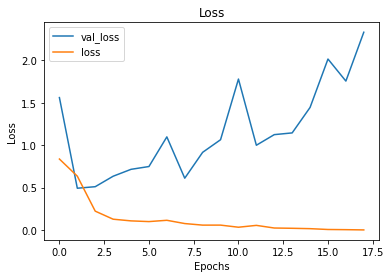

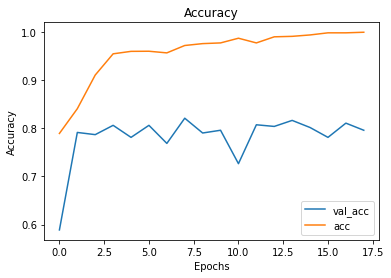

              precision    recall  f1-score   support

      normal       0.95      0.60      0.73       361
   pneumonia       0.78      0.98      0.87       517

    accuracy                           0.82       878
   macro avg       0.86      0.79      0.80       878
weighted avg       0.85      0.82      0.81       878



In [32]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_5',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> Again this model's performance is not improving over traing epochs.  The validation accuracy is hovering right around 80%, it's also over fitting drastically. Let's again try L2 regularization.

**$M_6$ - add L2 regularizers at 0.001**

Epoch 1/100
205/205 [==============================] - 59s 288ms/step - loss: 0.8755 - acc: 0.7778 - val_loss: 0.7743 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 59s 288ms/step - loss: 0.6167 - acc: 0.8115 - val_loss: 0.8100 - val_acc: 0.6424
Epoch 3/100
205/205 [==============================] - 67s 330ms/step - loss: 0.4230 - acc: 0.8610 - val_loss: 0.7821 - val_acc: 0.6515
Epoch 4/100
205/205 [==============================] - 65s 314ms/step - loss: 0.3709 - acc: 0.8820 - val_loss: 0.4493 - val_acc: 0.8326
Epoch 5/100
205/205 [==============================] - 57s 277ms/step - loss: 0.2669 - acc: 0.9278 - val_loss: 0.5151 - val_acc: 0.8155
Epoch 6/100
205/205 [==============================] - 58s 281ms/step - loss: 0.2347 - acc: 0.9361 - val_loss: 0.4500 - val_acc: 0.8360
Epoch 7/100
205/205 [==============================] - 60s 293ms/step - loss: 0.2185 - acc: 0.9471 - val_loss: 0.6268 - val_acc: 0.8041
Epoch 8/100
205/205 [===========================

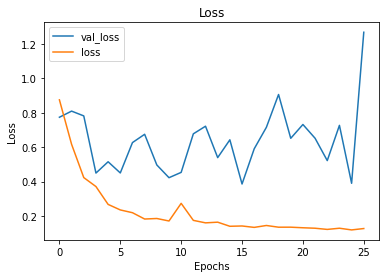

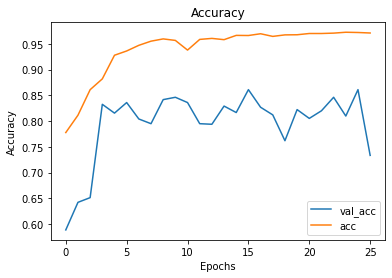

              precision    recall  f1-score   support

      normal       0.92      0.73      0.81       361
   pneumonia       0.83      0.96      0.89       517

    accuracy                           0.86       878
   macro avg       0.88      0.84      0.85       878
weighted avg       0.87      0.86      0.86       878



In [33]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_6',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> While this model did not improve on the accuracy, the regularization still does not appear to be working Lets decrease the learning rate to see if we are just stepping too far in our gradient descent.

**$M_7$ - Decrease learning_rate to 0.0005**

Epoch 1/100
205/205 [==============================] - 59s 284ms/step - loss: 0.7470 - acc: 0.7939 - val_loss: 0.7442 - val_acc: 0.5911
Epoch 2/100
205/205 [==============================] - 63s 305ms/step - loss: 0.3899 - acc: 0.8707 - val_loss: 0.6595 - val_acc: 0.6731
Epoch 3/100
205/205 [==============================] - 69s 335ms/step - loss: 0.2942 - acc: 0.9190 - val_loss: 0.9284 - val_acc: 0.7153
Epoch 4/100
205/205 [==============================] - 61s 298ms/step - loss: 0.2331 - acc: 0.9383 - val_loss: 0.7256 - val_acc: 0.7540
Epoch 5/100
205/205 [==============================] - 58s 280ms/step - loss: 0.2087 - acc: 0.9473 - val_loss: 0.5777 - val_acc: 0.8052
Epoch 6/100
205/205 [==============================] - 60s 293ms/step - loss: 0.2877 - acc: 0.9320 - val_loss: 0.8911 - val_acc: 0.7187
Epoch 7/100
205/205 [==============================] - 67s 329ms/step - loss: 0.2364 - acc: 0.9480 - val_loss: 0.5065 - val_acc: 0.8326
Epoch 8/100
205/205 [===========================

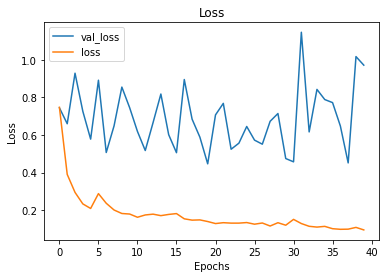

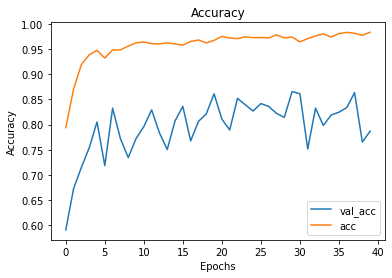

              precision    recall  f1-score   support

      normal       0.96      0.70      0.81       361
   pneumonia       0.83      0.98      0.90       517

    accuracy                           0.87       878
   macro avg       0.89      0.84      0.85       878
weighted avg       0.88      0.87      0.86       878



In [34]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_7',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> Decreasing the learning rate didn't help keep our loss metrics from fluctuating, and the val_accuracy itself is still fluctuating a decent amount shown in the above plot.  Let's add another form of regulatization through a dropout layer.

**$M_8$ - Add 10% dropout layer**

Epoch 1/100
205/205 [==============================] - 99s 468ms/step - loss: 1.0280 - acc: 0.7649 - val_loss: 1.0586 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 105s 508ms/step - loss: 0.4729 - acc: 0.8729 - val_loss: 0.5368 - val_acc: 0.8041
Epoch 3/100
205/205 [==============================] - 99s 482ms/step - loss: 0.2781 - acc: 0.9395 - val_loss: 0.5786 - val_acc: 0.8200
Epoch 4/100
205/205 [==============================] - 95s 448ms/step - loss: 0.2421 - acc: 0.9410 - val_loss: 0.4840 - val_acc: 0.8337
Epoch 5/100
205/205 [==============================] - 99s 484ms/step - loss: 0.2309 - acc: 0.9466 - val_loss: 0.8584 - val_acc: 0.7631
Epoch 6/100
205/205 [==============================] - 97s 467ms/step - loss: 0.2299 - acc: 0.9393 - val_loss: 0.3881 - val_acc: 0.8736
Epoch 7/100
205/205 [==============================] - 95s 462ms/step - loss: 0.2281 - acc: 0.9424 - val_loss: 0.7793 - val_acc: 0.7836
Epoch 8/100
205/205 [==========================

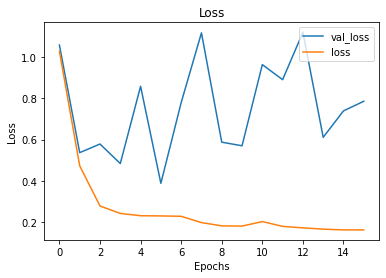

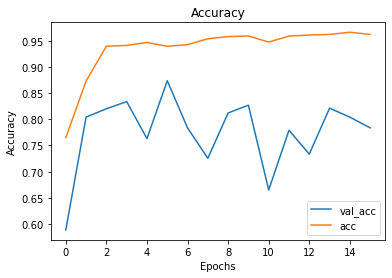

              precision    recall  f1-score   support

      normal       0.85      0.84      0.85       361
   pneumonia       0.89      0.89      0.89       517

    accuracy                           0.87       878
   macro avg       0.87      0.87      0.87       878
weighted avg       0.87      0.87      0.87       878



In [35]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.1))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_8',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> Adding the dropout layer did seem to prevent too much overfitting early on. Lets make the model more complex and increase the dropout rate so that we again.

**$M_8$ - Add another dense layer of 256, increase to 20% dropout layers**

Epoch 1/100
205/205 [==============================] - 74s 357ms/step - loss: 0.8997 - acc: 0.7995 - val_loss: 0.9886 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 69s 338ms/step - loss: 0.4449 - acc: 0.8573 - val_loss: 0.7089 - val_acc: 0.7198
Epoch 3/100
205/205 [==============================] - 70s 343ms/step - loss: 0.3162 - acc: 0.9098 - val_loss: 1.0787 - val_acc: 0.6560
Epoch 4/100
205/205 [==============================] - 62s 304ms/step - loss: 0.2560 - acc: 0.9327 - val_loss: 1.0149 - val_acc: 0.7221
Epoch 5/100
205/205 [==============================] - 64s 312ms/step - loss: 0.2174 - acc: 0.9483 - val_loss: 0.8468 - val_acc: 0.7620
Epoch 6/100
205/205 [==============================] - 67s 328ms/step - loss: 0.2271 - acc: 0.9451 - val_loss: 0.6311 - val_acc: 0.8007
Epoch 7/100
205/205 [==============================] - 63s 304ms/step - loss: 0.2282 - acc: 0.9459 - val_loss: 1.1758 - val_acc: 0.6822
Epoch 8/100
205/205 [===========================

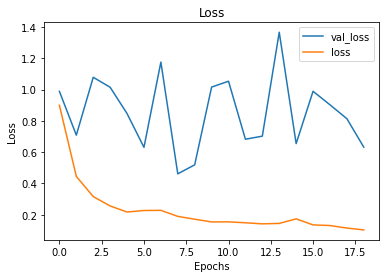

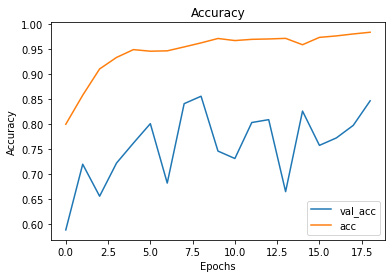

              precision    recall  f1-score   support

      normal       0.96      0.68      0.79       361
   pneumonia       0.81      0.98      0.89       517

    accuracy                           0.86       878
   macro avg       0.89      0.83      0.84       878
weighted avg       0.87      0.86      0.85       878



In [36]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_8',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> Our above model hasn't approve upon the very first model. The model seems to be getting better with higher resolution and then some regularization.  Let's follow this strategy and increase resolution to (256, 256) and subsequently add regularization.  Also, let's increase the batch size to get a better estimate on the error gradient (so long as the CPU can handle it).

**$M_9$ - increase resolution to (256, 256), remove regularization, increase batch_size**

In [120]:
# get all the data in the directory split/test, and reshape them
size = (256, 256)
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=50,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/100
82/82 [==============================] - 189s 2s/step - loss: 1.3430 - acc: 0.7480 - val_loss: 0.7396 - val_acc: 0.5888
Epoch 2/100
82/82 [==============================] - 148s 2s/step - loss: 0.5991 - acc: 0.8129 - val_loss: 0.9104 - val_acc: 0.5900
Epoch 3/100
82/82 [==============================] - 151s 2s/step - loss: 0.3581 - acc: 0.8629 - val_loss: 0.6265 - val_acc: 0.7312
Epoch 4/100
82/82 [==============================] - 189s 2s/step - loss: 1.0481 - acc: 0.8766 - val_loss: 0.6906 - val_acc: 0.6492
Epoch 5/100
82/82 [==============================] - 152s 2s/step - loss: 0.2859 - acc: 0.8702 - val_loss: 0.6230 - val_acc: 0.7426
Epoch 6/100
82/82 [==============================] - 148s 2s/step - loss: 0.2233 - acc: 0.9105 - val_loss: 0.8470 - val_acc: 0.7289
Epoch 7/100
82/82 [==============================] - 155s 2s/step - loss: 0.1601 - acc: 0.9359 - val_loss: 0.5856 - val_acc: 0.8132
Epoch 8/100
82/82 [==============================] - 154s 2s/step - loss: 0.

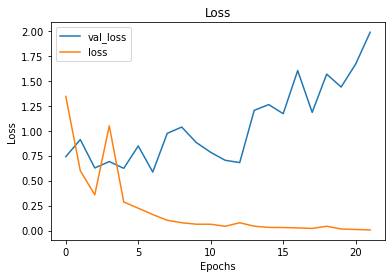

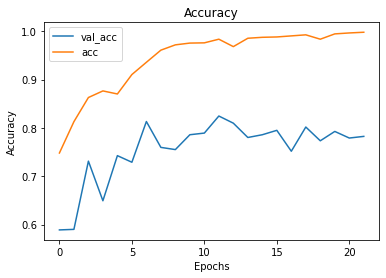

              precision    recall  f1-score   support

      normal       0.92      0.63      0.75       361
   pneumonia       0.79      0.96      0.87       517

    accuracy                           0.82       878
   macro avg       0.85      0.79      0.81       878
weighted avg       0.84      0.82      0.82       878



In [38]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_9',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> The model is overfitting and not really generalizing well on the validation set as evidence that the loss increases through epochs.  Let's try changing the architecture by removing the dense 256 layer and regularization.

**$M_{10}$** - remove regularization, and dense layer with 256 nodes.

Epoch 1/100
82/82 [==============================] - 111s 1s/step - loss: 1.0904 - acc: 0.7522 - val_loss: 0.6987 - val_acc: 0.5888
Epoch 2/100
82/82 [==============================] - 118s 1s/step - loss: 0.4234 - acc: 0.8437 - val_loss: 1.0068 - val_acc: 0.6173
Epoch 3/100
82/82 [==============================] - 113s 1s/step - loss: 0.2317 - acc: 0.9161 - val_loss: 0.6562 - val_acc: 0.7870
Epoch 4/100
82/82 [==============================] - 140s 2s/step - loss: 0.1587 - acc: 0.9366 - val_loss: 0.6944 - val_acc: 0.7813
Epoch 5/100
82/82 [==============================] - 186s 2s/step - loss: 0.1043 - acc: 0.9583 - val_loss: 0.8415 - val_acc: 0.7665
Epoch 6/100
82/82 [==============================] - 196s 2s/step - loss: 0.1055 - acc: 0.9563 - val_loss: 0.8922 - val_acc: 0.7790
Epoch 7/100
82/82 [==============================] - 134s 2s/step - loss: 0.0758 - acc: 0.9685 - val_loss: 0.5898 - val_acc: 0.8349
Epoch 8/100
82/82 [==============================] - 117s 1s/step - loss: 0.

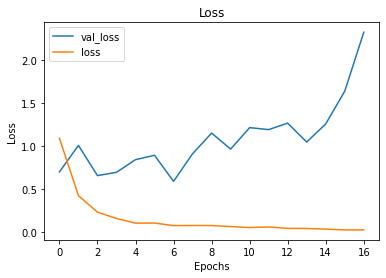

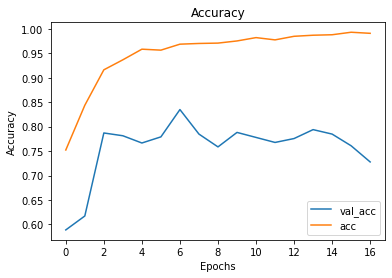

              precision    recall  f1-score   support

      normal       0.94      0.64      0.76       361
   pneumonia       0.79      0.97      0.87       517

    accuracy                           0.83       878
   macro avg       0.87      0.81      0.82       878
weighted avg       0.85      0.83      0.83       878



In [40]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 256, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_10',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> Model performance did not and still have drastic overfitting. Add regularization back in.

**$M_{11}$ - add regularization**

Epoch 1/100
82/82 [==============================] - 148s 2s/step - loss: 0.9921 - acc: 0.7968 - val_loss: 0.8671 - val_acc: 0.5888
Epoch 2/100
82/82 [==============================] - 178s 2s/step - loss: 0.5440 - acc: 0.8363 - val_loss: 0.8965 - val_acc: 0.6640
Epoch 3/100
82/82 [==============================] - 165s 2s/step - loss: 0.3680 - acc: 0.8968 - val_loss: 0.7680 - val_acc: 0.7608
Epoch 4/100
82/82 [==============================] - 179s 2s/step - loss: 0.3267 - acc: 0.9173 - val_loss: 1.1169 - val_acc: 0.6902
Epoch 5/100
82/82 [==============================] - 196s 2s/step - loss: 0.3449 - acc: 0.9056 - val_loss: 0.5079 - val_acc: 0.8371
Epoch 6/100
82/82 [==============================] - 183s 2s/step - loss: 0.2672 - acc: 0.9339 - val_loss: 0.8900 - val_acc: 0.7346
Epoch 7/100
82/82 [==============================] - 140s 2s/step - loss: 0.2337 - acc: 0.9495 - val_loss: 0.9196 - val_acc: 0.7551
Epoch 8/100
82/82 [==============================] - 131s 2s/step - loss: 0.

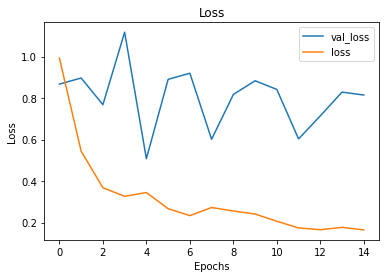

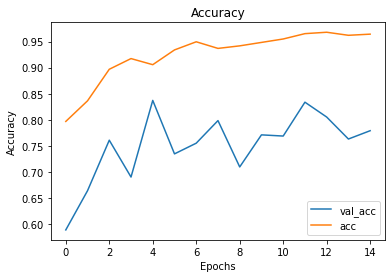

              precision    recall  f1-score   support

      normal       0.90      0.68      0.77       361
   pneumonia       0.81      0.95      0.87       517

    accuracy                           0.84       878
   macro avg       0.86      0.81      0.82       878
weighted avg       0.85      0.84      0.83       878



In [41]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(256, 256, 1),
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_11',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)

<u>Notes:</u> Model performance did not improve, and still have drastic overfitting.

$M_{0}$ was the best model so far with 87% accuracy and an F1 score of 0.9, while $M_{8}$ was close. Lets go back to this model and see if we can improve on it.  Now, well add in some image augmentation techniques.

**$M_{12}$ - revert to $M_{8}$ and add image augmentation**
* rotation_range=15
* fill_mode=nearest
* width_shift_range=.1
* height_shift_range=.2
* brightness_range=[.8,1.2]

In [125]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/100
205/205 [==============================] - 68s 330ms/step - loss: 0.9456 - acc: 0.8085 - val_loss: 1.1073 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 64s 312ms/step - loss: 0.6291 - acc: 0.8090 - val_loss: 1.1185 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 71s 346ms/step - loss: 0.6034 - acc: 0.8090 - val_loss: 0.7518 - val_acc: 0.5888
Epoch 4/100
205/205 [==============================] - 67s 326ms/step - loss: 0.6007 - acc: 0.8090 - val_loss: 0.7503 - val_acc: 0.5888
Epoch 5/100
205/205 [==============================] - 64s 310ms/step - loss: 0.5349 - acc: 0.8090 - val_loss: 0.9132 - val_acc: 0.5888
Epoch 6/100
205/205 [==============================] - 64s 314ms/step - loss: 0.4691 - acc: 0.8090 - val_loss: 0.6476 - val_acc: 0.5888
Epoch 7/100
205/205 [==============================] - 72s 352ms/step - loss: 0.4759 - acc: 0.8022 - val_loss: 0.7029 - val_acc: 0.5888
Epoch 8/100
205/205 [===========================

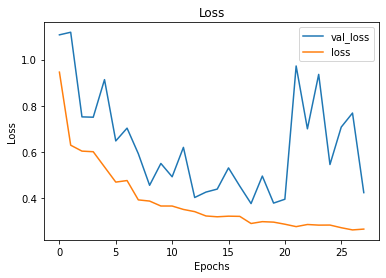

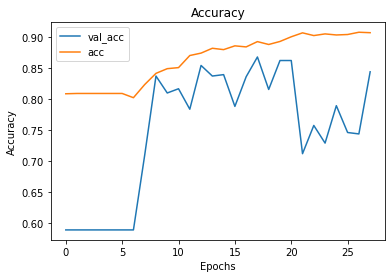

              precision    recall  f1-score   support

      normal       0.79      0.93      0.85       361
   pneumonia       0.94      0.83      0.88       517

    accuracy                           0.87       878
   macro avg       0.87      0.88      0.87       878
weighted avg       0.88      0.87      0.87       878



In [43]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_12',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)


<u>Notes:</u> It appears as though image augmentation has helped decrease overfitting. Let's decrease the amount of L2 regularization.

**$M_{13}$ - decrease L2 regularization**

Epoch 1/100
205/205 [==============================] - 121s 588ms/step - loss: 0.6383 - acc: 0.8071 - val_loss: 0.7883 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 107s 524ms/step - loss: 0.5629 - acc: 0.8090 - val_loss: 0.7127 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 116s 565ms/step - loss: 0.5517 - acc: 0.8090 - val_loss: 0.8944 - val_acc: 0.5888
Epoch 4/100
205/205 [==============================] - 101s 492ms/step - loss: 0.4940 - acc: 0.8090 - val_loss: 0.7259 - val_acc: 0.5888
Epoch 5/100
205/205 [==============================] - 91s 446ms/step - loss: 0.4571 - acc: 0.8146 - val_loss: 1.2252 - val_acc: 0.5888
Epoch 6/100
205/205 [==============================] - 117s 574ms/step - loss: 0.4435 - acc: 0.8198 - val_loss: 0.5730 - val_acc: 0.7779
Epoch 7/100
205/205 [==============================] - 124s 608ms/step - loss: 0.3709 - acc: 0.8337 - val_loss: 0.7553 - val_acc: 0.7107
Epoch 8/100
205/205 [=====================

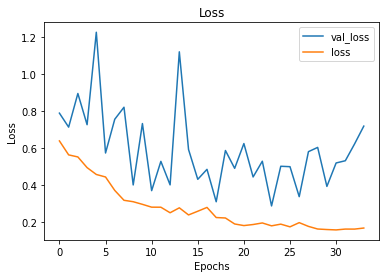

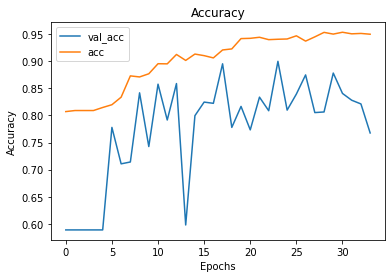

              precision    recall  f1-score   support

      normal       0.90      0.85      0.88       361
   pneumonia       0.90      0.93      0.92       517

    accuracy                           0.90       878
   macro avg       0.90      0.89      0.90       878
weighted avg       0.90      0.90      0.90       878



In [44]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_13',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)


<u>Notes:</u> Great this is the best model yet.  The model achieved its highest accuracy and overfit by about 4%. Now let's see if increasing batch size will gives us a better estimate for each step the model makes.

**$M_{14}$ - increase batch_size to 30**

In [127]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=30,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=30,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=30,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/100
137/137 [==============================] - 64s 462ms/step - loss: 0.6403 - acc: 0.8090 - val_loss: 0.7616 - val_acc: 0.5888
Epoch 2/100
137/137 [==============================] - 64s 466ms/step - loss: 0.6383 - acc: 0.8090 - val_loss: 1.1948 - val_acc: 0.5888
Epoch 3/100
137/137 [==============================] - 68s 497ms/step - loss: 0.8899 - acc: 0.8090 - val_loss: 1.0374 - val_acc: 0.5888
Epoch 4/100
137/137 [==============================] - 75s 547ms/step - loss: 0.4754 - acc: 0.8090 - val_loss: 1.0587 - val_acc: 0.5888
Epoch 5/100
137/137 [==============================] - 71s 520ms/step - loss: 0.5545 - acc: 0.8090 - val_loss: 0.7803 - val_acc: 0.5888
Epoch 6/100
137/137 [==============================] - 68s 500ms/step - loss: 0.4532 - acc: 0.8100 - val_loss: 0.5574 - val_acc: 0.7062
Epoch 7/100
137/137 [==============================] - 72s 526ms/step - loss: 0.4054 - acc: 0.8217 - val_loss: 0.5652 - val_acc: 0.7494
Epoch 8/100
137/137 [===========================

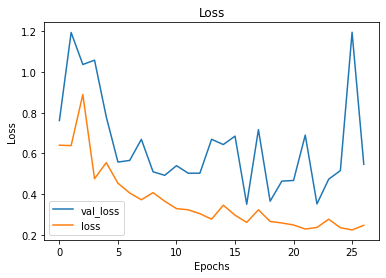

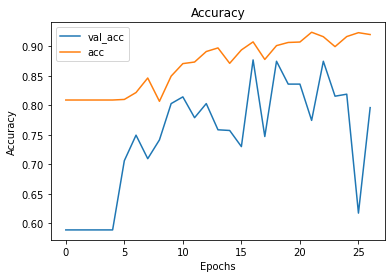

              precision    recall  f1-score   support

      normal       0.92      0.77      0.84       361
   pneumonia       0.85      0.95      0.90       517

    accuracy                           0.88       878
   macro avg       0.89      0.86      0.87       878
weighted avg       0.88      0.88      0.87       878



In [46]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_14',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)


<u>Notes:</u> The model did not stablize at all and performed poorly. Lets revert to batch_size=20 and decrease the learning rate to 0.0001.

**$M_{15}$ - decrease learning rate to 0.0001**

In [129]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/100
205/205 [==============================] - 91s 442ms/step - loss: 0.6154 - acc: 0.8044 - val_loss: 1.1174 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 116s 568ms/step - loss: 0.5724 - acc: 0.8090 - val_loss: 0.7903 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 82s 401ms/step - loss: 0.5377 - acc: 0.8090 - val_loss: 0.7131 - val_acc: 0.5888
Epoch 4/100
205/205 [==============================] - 68s 331ms/step - loss: 0.4820 - acc: 0.8039 - val_loss: 0.6416 - val_acc: 0.8007
Epoch 5/100
205/205 [==============================] - 72s 352ms/step - loss: 0.4932 - acc: 0.8078 - val_loss: 0.5943 - val_acc: 0.6822
Epoch 6/100
205/205 [==============================] - 64s 313ms/step - loss: 0.4141 - acc: 0.8476 - val_loss: 0.8191 - val_acc: 0.6025
Epoch 7/100
205/205 [==============================] - 63s 308ms/step - loss: 0.3945 - acc: 0.8532 - val_loss: 0.4324 - val_acc: 0.8542
Epoch 8/100
205/205 [==========================

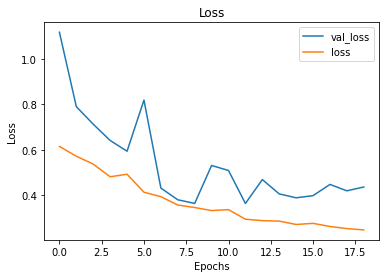

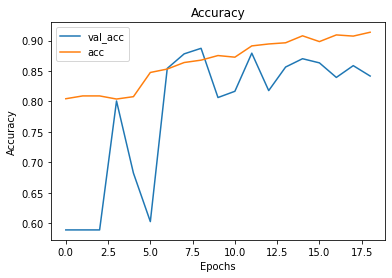

              precision    recall  f1-score   support

      normal       0.87      0.86      0.86       361
   pneumonia       0.90      0.91      0.90       517

    accuracy                           0.89       878
   macro avg       0.88      0.88      0.88       878
weighted avg       0.89      0.89      0.89       878



In [48]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_15',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)


<u>Notes:</u> The model performed fairly well but did not reach the performance of the $M_{14}$. The loss is not fluctuating as much either. Let's try some more preprocessing and see if we can enhance the images to bring out the patterns that show pneumonia.

**Histogram Equalization** - Here we'll make the dark parts of the images darker and the brighter parts a bit brighter using histogram equalization. This should illuminate the patterns that show pneumonia a little more, and therefore may be easier to recognize. The downside is that random noise will also be enhanced. As a results, we may have to tweak the model architecture and increase the regularization so as not to follow the random noise.

Original X-ray Image:


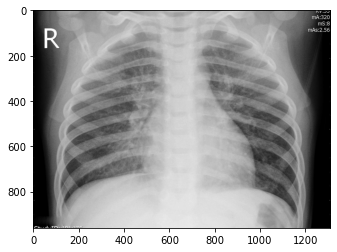

In [49]:
image = PIL.Image.open(f"chest_xray/train/PNEUMONIA/{train_pneum[0]}")
print('Original X-ray Image:')
plt.imshow(image, cmap='gray');

Enhanced X-ray Image:


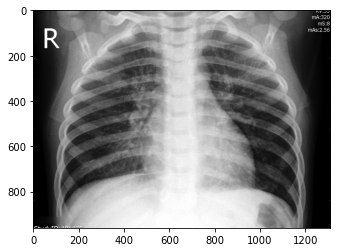

In [50]:
src = cv.imread(f"chest_xray/train/PNEUMONIA/{train_pneum[0]}")
src = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
equ = cv.equalizeHist(src, cv.COLOR_BGR2GRAY)
image = PIL.Image.fromarray(equ)
print('Enhanced X-ray Image:')
plt.imshow(image, cmap='gray');

Above you can see the difference histogram equalization makes.  In particular, the darkness inbetween the rib cage looks much darker in the second photo and all the bones and organs look a little brighter. Now, let's use histogram equalization to process all of the training, validation, and test images into a new folder called "enhanced".

In [51]:
# Create list of paths to each folder of data
paths = ['chest_xray/train/normal', 'chest_xray/train/pneumonia', 'chest_xray/test/normal', 
         'chest_xray/test/pneumonia', 'chest_xray/val/normal', 'chest_xray/val/pneumonia']
# For each folder
for path in paths:
    
    # Create a corresponding folder for the enhanced images
    enhanced = f'enhanced{path[10:]}'
    os.makedirs(enhanced)
    
    # Get the file names for each image in the current path
    data = [file for file in os.listdir(path=path) if file.endswith('jpeg')]
    
    # For each image in the current folder, enhance it and add it to the corresponding enhanced folder
    for xray in data:
        src = cv.imread(f'{path}/{xray}')
        src = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
        equ = cv.equalizeHist(src, cv.COLOR_BGR2GRAY)
        im = PIL.Image.fromarray(equ)
        im.save(enhanced+'/'+xray)   
        

In [52]:
# Create paths to new enhanced data folders
enhanced_train = 'enhanced/train'
enhanced_test = 'enhanced/test'
enhanced_val = 'enhanced/val'

$M_{16}$ - Run simple model on the enhanced data to get a baseline

In [131]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen_en = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        enhanced_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
val_gen_en = ImageDataGenerator(rescale=1./255).flow_from_directory(
        enhanced_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
test_gen_en = ImageDataGenerator(rescale=1./255).flow_from_directory(
        enhanced_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


Epoch 1/100
205/205 [==============================] - 103s 494ms/step - loss: 0.7555 - acc: 0.8090 - val_loss: 0.6797 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 105s 503ms/step - loss: 0.5210 - acc: 0.8090 - val_loss: 0.5969 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 81s 394ms/step - loss: 0.3986 - acc: 0.8329 - val_loss: 0.4331 - val_acc: 0.8212
Epoch 4/100
205/205 [==============================] - 107s 524ms/step - loss: 0.3341 - acc: 0.8490 - val_loss: 0.5097 - val_acc: 0.8098
Epoch 5/100
205/205 [==============================] - 93s 457ms/step - loss: 0.3287 - acc: 0.8551 - val_loss: 0.7152 - val_acc: 0.5888
Epoch 6/100
205/205 [==============================] - 77s 376ms/step - loss: 0.2905 - acc: 0.8729 - val_loss: 0.4079 - val_acc: 0.8360
Epoch 7/100
205/205 [==============================] - 93s 449ms/step - loss: 0.2889 - acc: 0.8822 - val_loss: 0.4244 - val_acc: 0.8360
Epoch 8/100
205/205 [========================

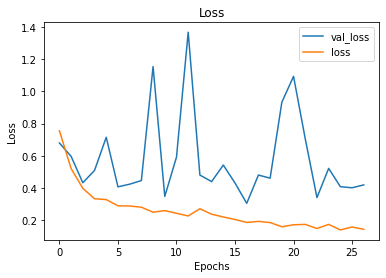

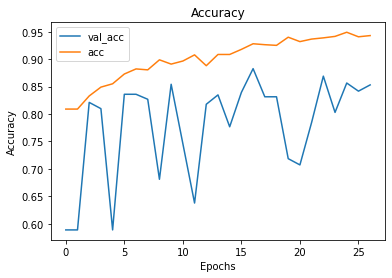

              precision    recall  f1-score   support

      normal       0.86      0.85      0.86       361
   pneumonia       0.90      0.90      0.90       517

    accuracy                           0.88       878
   macro avg       0.88      0.88      0.88       878
weighted avg       0.88      0.88      0.88       878



In [54]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_16',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen_en, 
                    val_gen=val_gen_en, 
                    metric='acc', 
                    epochs=100)


<u>Notes:</u> Accuracy is fluctuating as in our other models.  Lets repeat the architecture of the best model and train on the enhanced data.  

**$M_{17}$ - repeat $M_{16}$ architecture**

Epoch 1/100
205/205 [==============================] - 66s 318ms/step - loss: 0.6216 - acc: 0.7951 - val_loss: 0.7586 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 69s 335ms/step - loss: 0.5605 - acc: 0.8090 - val_loss: 0.6538 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 73s 353ms/step - loss: 0.4659 - acc: 0.8117 - val_loss: 0.5268 - val_acc: 0.8314
Epoch 4/100
205/205 [==============================] - 69s 335ms/step - loss: 0.3887 - acc: 0.8566 - val_loss: 0.5000 - val_acc: 0.7893
Epoch 5/100
205/205 [==============================] - 68s 331ms/step - loss: 0.3734 - acc: 0.8683 - val_loss: 0.4684 - val_acc: 0.8314
Epoch 6/100
205/205 [==============================] - 66s 322ms/step - loss: 0.3603 - acc: 0.8559 - val_loss: 0.4319 - val_acc: 0.8462
Epoch 7/100
205/205 [==============================] - 69s 334ms/step - loss: 0.3415 - acc: 0.8673 - val_loss: 0.4228 - val_acc: 0.8497
Epoch 8/100
205/205 [===========================

Epoch 61/100
205/205 [==============================] - 56s 273ms/step - loss: 0.1394 - acc: 0.9610 - val_loss: 0.4615 - val_acc: 0.8405
INFO:tensorflow:Assets written to: models/model_20\assets


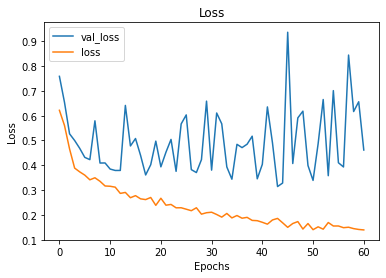

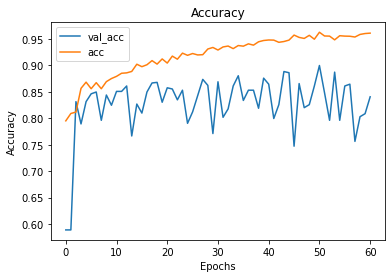

              precision    recall  f1-score   support

      normal       0.88      0.87      0.88       361
   pneumonia       0.91      0.92      0.92       517

    accuracy                           0.90       878
   macro avg       0.90      0.90      0.90       878
weighted avg       0.90      0.90      0.90       878



In [83]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_17',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                    train_gen=train_gen_en, 
                    val_gen=val_gen_en, 
                    metric='acc', 
                    epochs=100)


<u>Notes:</u> The model performance has improved but still fluctuates a bit.   Let's go back to using the non-enhanced data for a bit since there's a chance all we did was enhance random noise.  From here lets try to stabilize the model more.  I'll increase the dropout rate to 0.5.

In [7]:
# get all the data in the directory split/test, and reshape them
size = (128,128)
train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=15, 
                               fill_mode='nearest',
                               width_shift_range=.1,
                               height_shift_range=.2,
                               brightness_range= [.8,1.2]).flow_from_directory(
        data_train,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle = False) 

# get all the data in the directory split/validation 
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_val,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

# get all the data in the directory split/train 
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_test,
        target_size=size,
        color_mode='grayscale',
        batch_size=20,
        class_mode='binary',
        shuffle=False) 

Found 4100 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 878 images belonging to 2 classes.


**$M_{18}$ - best architecture, increase the dropout rate to 0.5.**

Epoch 1/100
205/205 [==============================] - 69s 336ms/step - loss: 0.6222 - acc: 0.8037 - val_loss: 0.8668 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 76s 370ms/step - loss: 0.5616 - acc: 0.8090 - val_loss: 0.7384 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 79s 383ms/step - loss: 0.5420 - acc: 0.8073 - val_loss: 0.8329 - val_acc: 0.5888
Epoch 4/100
205/205 [==============================] - 80s 392ms/step - loss: 0.4530 - acc: 0.8161 - val_loss: 0.5451 - val_acc: 0.8212
Epoch 5/100
205/205 [==============================] - 76s 371ms/step - loss: 0.3873 - acc: 0.8307 - val_loss: 0.4600 - val_acc: 0.8497
Epoch 6/100
205/205 [==============================] - 86s 421ms/step - loss: 0.3666 - acc: 0.8551 - val_loss: 0.4384 - val_acc: 0.8303
Epoch 7/100
205/205 [==============================] - 99s 484ms/step - loss: 0.3602 - acc: 0.8490 - val_loss: 0.4344 - val_acc: 0.8542
Epoch 8/100
205/205 [===========================

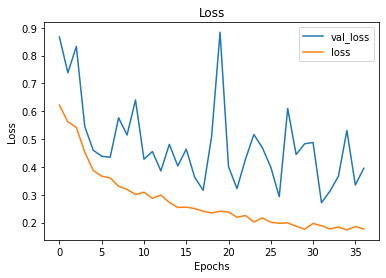

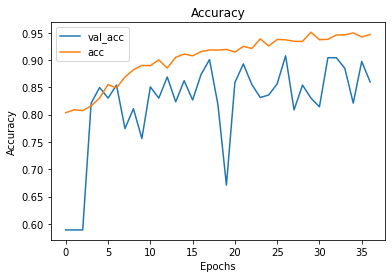

              precision    recall  f1-score   support

      normal       0.92      0.85      0.88       361
   pneumonia       0.90      0.95      0.92       517

    accuracy                           0.91       878
   macro avg       0.91      0.90      0.90       878
weighted avg       0.91      0.91      0.91       878



In [78]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_18',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)


<u>Notes:</u> While still fluctuating, at least its range of fluctuation generally is smaller.  It seems like the learning rate may need to be smaller but when decreased, the model gets stuck at a local minimum and ceases to train further.  Let's train a model for 5 epochs at a higher learning rate then stop it.  Then we'll reload this architecture into a new model and train it with a smaller learning rate so as to hop over the first local minimum.

**$M_{19}$ - increase learning rate to 0.0005**

Epoch 1/5
205/205 [==============================] - 106s 513ms/step - loss: 0.7015 - acc: 0.8068 - val_loss: 0.8382 - val_acc: 0.5888
Epoch 2/5
205/205 [==============================] - 116s 566ms/step - loss: 0.7836 - acc: 0.8051 - val_loss: 0.7255 - val_acc: 0.5888
Epoch 3/5
205/205 [==============================] - 75s 365ms/step - loss: 0.5676 - acc: 0.8022 - val_loss: 0.8413 - val_acc: 0.5888
Epoch 4/5
205/205 [==============================] - 115s 559ms/step - loss: 0.5739 - acc: 0.8090 - val_loss: 0.9168 - val_acc: 0.5888
Epoch 5/5
205/205 [==============================] - 118s 577ms/step - loss: 0.4751 - acc: 0.8102 - val_loss: 0.7624 - val_acc: 0.5888
INFO:tensorflow:Assets written to: models/model_31\assets


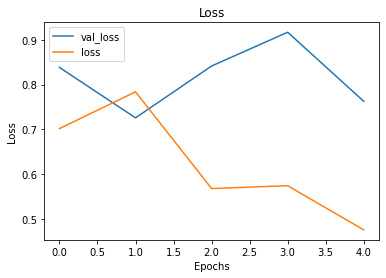

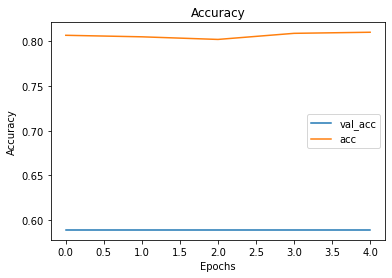

C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\holde\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       361
   pneumonia       0.59      1.00      0.74       517

    accuracy                           0.59       878
   macro avg       0.29      0.50      0.37       878
weighted avg       0.35      0.59      0.44       878



In [86]:
# Instantiate model and build layers
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3,), activation='relu', input_shape=(128, 128, 1), 
                        kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3,), activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(1, activation='sigmoid'))

model = train_model(name='model_19',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=5)


<u>Notes:</u> Model appears to be training passed the local minimum.  Reload the model and decrease the learning rate.

**$M_{20}$ - train previous model with decreased learning rate**

Epoch 1/100
205/205 [==============================] - 102s 495ms/step - loss: 0.3816 - acc: 0.8093 - val_loss: 0.7347 - val_acc: 0.5888
Epoch 2/100
205/205 [==============================] - 114s 559ms/step - loss: 0.3699 - acc: 0.8095 - val_loss: 0.7081 - val_acc: 0.5888
Epoch 3/100
205/205 [==============================] - 99s 484ms/step - loss: 0.3620 - acc: 0.8093 - val_loss: 0.6952 - val_acc: 0.5888
Epoch 4/100
205/205 [==============================] - 99s 486ms/step - loss: 0.3524 - acc: 0.8105 - val_loss: 0.6991 - val_acc: 0.5888
Epoch 5/100
205/205 [==============================] - 116s 564ms/step - loss: 0.3524 - acc: 0.8154 - val_loss: 0.6756 - val_acc: 0.5900
Epoch 6/100
205/205 [==============================] - 101s 494ms/step - loss: 0.3473 - acc: 0.8176 - val_loss: 0.6416 - val_acc: 0.6002
Epoch 7/100
205/205 [==============================] - 88s 429ms/step - loss: 0.3418 - acc: 0.8195 - val_loss: 0.6202 - val_acc: 0.6230
Epoch 8/100
205/205 [=======================

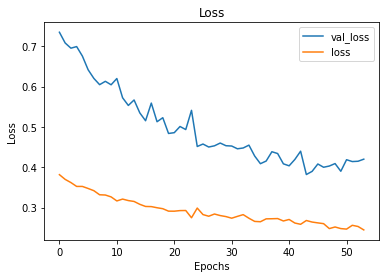

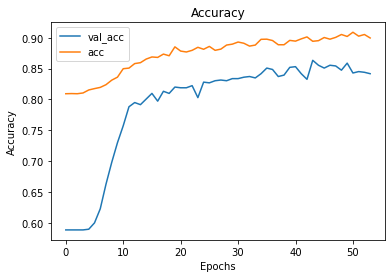

              precision    recall  f1-score   support

      normal       0.85      0.81      0.83       361
   pneumonia       0.87      0.90      0.89       517

    accuracy                           0.86       878
   macro avg       0.86      0.86      0.86       878
weighted avg       0.86      0.86      0.86       878



In [87]:
model = keras.models.load_model('models/model_19')
model = train_model(name='model_20',
                    model=model, 
                    loss='binary_crossentropy', 
                    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                    train_gen=train_gen, 
                    val_gen=val_gen, 
                    metric='acc', 
                    epochs=100)


<u>Notes:</u> Finally, it appears we have a model that training consistently.  This model does not achieve the highest accuracy of the bunch but does train dependably.

In [159]:
results.to_csv('results')
results

,precision,recall,f1,accuracy
model_0,0.84,0.96,0.9,0.871298
model_1,0.82,0.97,0.89,0.855353
model_2,0.59,1,0.74,0.588838
model_3,0.85,0.95,0.9,0.872437
model_4,0.81,0.98,0.89,0.850797
model_5,0.78,0.98,0.87,0.821185
model_6,0.83,0.96,0.89,0.861048
model_7,0.83,0.98,0.9,0.865604
model_8,0.81,0.98,0.89,0.855353
model_9,0.76,0.98,0.86,0.810934


Now that we have iterated on the model and improved it, let's pick a model and evaluate it.
## Evaluation
___
Shown above is the results dataframe with precision, recall, f1-score and accuracy for each model.

**Accuracy:**<br>
We have accuracy scores that range from 59-91%, a huge range.  While it might seem logical to just choose the model with the highest accuracy, that might be a bad choice. As we saw when training each model, most of these had large variability in accuracy scores while training over epochs.  Inconsistent training indicates that the model is randomly highlighting different patterns in the data but has not yet refined itself to a model that will generalize well on unseen data. Ideally we would have a model that improves consistently until some point in training when it starts to overfit towards the training data and the accuracy on the validation set plateaues and then declines.  For this reason, it's best to choose the most consistent model ($M_{20}$), as it trains consistently and slowly before starting to overfit.

Below, I'll define a function to output the final test results of our model, and it's confusion matrix.

In [14]:
def scores(model, gen, threshold):
    '''
    Display the classification report, and confusion matrix for each model
    
    PARAMETERS
    ----------
    model - keras model
    gen - which dataset to run accuracy metrics on (val data or holdout test data)    
    '''
    # Get the predictions
    preds = model.predict(gen)
    preds[preds>=threshold]=1
    preds[preds<threshold]=0
    
    # Print the classification report
    print(classification_report(gen.labels, preds))
    
    # Create the confusion matrix and output it
    cm = confusion_matrix(gen.labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'pneumonia'],)
    disp.plot(cmap=plt.cm.Blues)
    plt.grid(None)
    plt.show()

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       439
           1       0.95      0.81      0.87       439

    accuracy                           0.88       878
   macro avg       0.89      0.88      0.88       878
weighted avg       0.89      0.88      0.88       878



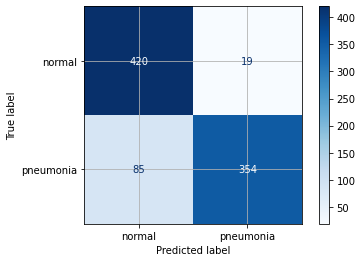

In [15]:
# Load the final model and test on the validation set
final_model = keras.models.load_model('models/model_20')
scores(final_model, test_gen, threshold=.5);

**Validation Test Results:**<br>
Great! The good news is the final model overall accuracy improved from the validation results by 2%.  However, it also classified 85 people as false negatives (9.6%) which is up from the 69 false negatives when tested on the validation data. The model was 95% precise with pneumonia predictions (correctly classified pneumonia with 81% accuracy) and 83% precise with normal predictions. Over all the model correctly labeled 96% of normal patients, 81% of pneumonia patients, for an overall accuracy of 88%.

**Compare Results:** <br>
Below I'll create a plot to compare the accuracy of the final model given the training, validation, and test set.

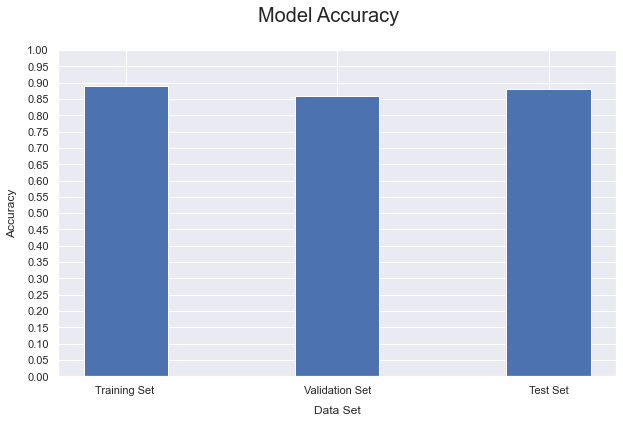

In [165]:
# Create barplot showing accuracy
fig = plt.figure()
sns.set(rc = {'figure.figsize':(10,6)})
plt.bar(x=['Training Set ', 'Validation Set', 'Test Set'], height = [0.89, 0.86, 0.88],width=.4)
plt.ylabel('Accuracy', labelpad=10)
plt.xlabel('Data Set', labelpad=10);
plt.yticks(np.linspace(0, 1, 21));
fig.suptitle('Model Accuracy', fontsize=20);

The above barplot shows the accuracies achieved by the final model when tested on each set of data.  The model achieved a greatest accuracy of 89% on the training set as expected.  The model performed at 86% accuracy on the validation set. The model actually performed better on the testing set than on the validation set which is an indication that the model did generalize well with a 88% accuracy.  Also important to note that the validation set and the testing set are the same size (898 samples) and therefore equally reliable.

**Area Under the Curve** - Next let's look at the AUC to get a sense for how the model's true positive and false positive rates look for each decision threshold. I'll start by defining a function to plot the auc

In [166]:
def auc_plot(model, gen):
    '''
    Plot the roc curve given the model and the validation data
    
    PARAMETERS
    ----------
    model - Sequential() keras model, trained
    gen - ImageDataGenerator, pre-instantiated with data
    '''
    # Use 
    prob = model.predict(gen)
    
    fpr, tpr, thresholds =  roc_curve(gen.labels, prob)
    
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    print('Model AUC:',round(auc(fpr, tpr),3))

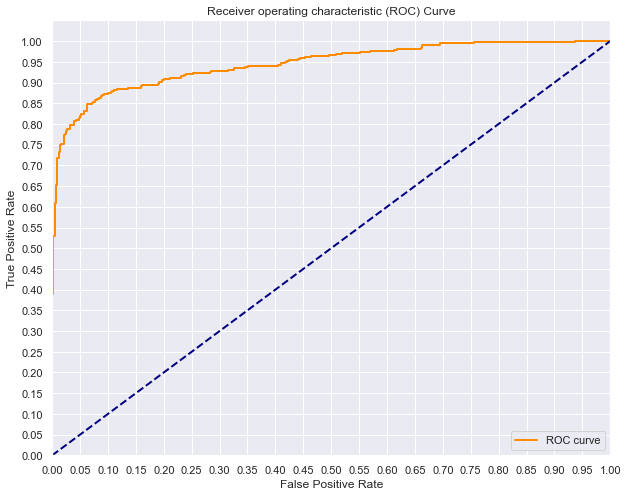

Model AUC: 0.945


In [167]:
auc_plot(final_model, test_gen)

As shown in the above plot, the auc is 0.945 which is pretty good.  The decision threshold of 0.5 gave us a true positive rate of 0.81 which appears close to the top left corner of the plot as possible - meaning that our trade off between true positives and false positives mostly balanced.  However the curve is pretty steap here. It seems that if we decrease the threshold a bit, we could increase the true positive rate without drastically increasing the false positive rate.  To make it more clear, let's plot. Specificity (True Negative Rate) and Sensitivity (True Positive Rate) against the decision thresholds.  Specificity and sensitivity will show the tradeoff between obtaining more true positives for decreased true negatives and vice versa. I'll start by defining a fuction `tpr_tnr()` to the TPR and TNR for each decision threshold input to the function.

In [189]:
def tpr_tnr(preds, thresholds):
    '''
    Get the true negatives for each threshold given the threshold and predictions
    
    PARAMETERS
    -----------
    preds - float, output predictions from the given model
    thresholds - floats, 
    '''
    specificity = []
    sensitivity = []

    # For each threshold
    for t in thresholds:

        # Classify predictions as either 0 or 1
        temp_preds = preds.copy()
        temp_preds[temp_preds>=t]=1
        temp_preds[temp_preds<t]=0

        # Calculate Confusion Matrix
        cm = confusion_matrix(test_gen.labels, temp_preds)
        tp_pp = cm[0][0]
        tp_pn = cm[0][1]
        tn_pp = cm[1][0]
        tn_pn = cm[1][1]

        # Calculate True negative rate and append to list
        specificity.append((tn_pn)/(tn_pn + tn_pp))
        sensitivity.append(tp_pp/(tp_pp + tp_pn))
    return specificity, sensitivity

In [190]:
# Get the raw predictions from the model
prob = final_model.predict(test_gen)

# Define thresholds for ploting 
thresholds = np.linspace(.01,1,100)

# Get the specificity and sensitivities using above function
specificity, sensitivity = tpr_tnr(prob, thresholds)

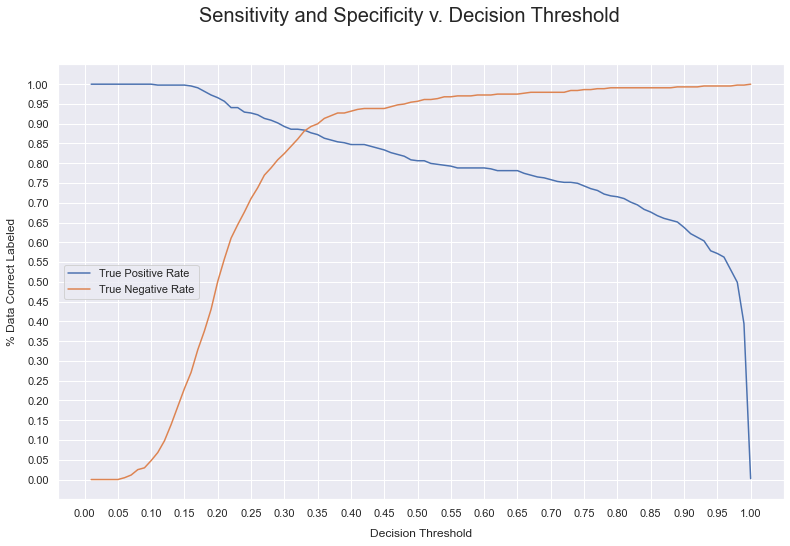

In [220]:
# Create plot showing Sensitivity and Specificity v. Decision Threshold
sns.set_style("darkgrid")
sns.set(rc = {'figure.figsize':(13,8)})
fig = plt.figure()
plt.plot(thresholds, specificity)
plt.plot(thresholds, sensitivity)
plt.ylabel('% Data Correct Labeled', labelpad=10)
plt.xlabel('Decision Threshold',labelpad=10)
plt.legend(['True Positive Rate','True Negative Rate'])
plt.yticks(np.linspace(0, 1, 21))
plt.xticks(np.linspace(0, 1, 21));
fig.suptitle('Sensitivity and Specificity v. Decision Threshold', fontsize=20);

The above shows the trade-off between number of correctly classified true positives and true negatives if you move the decision threshold value.  If we move the decision threshold from 0.5 to 0.42 it does seem like we can attain a few more true positives at without decreasing the number of true negatives too much.  Let's move the threshold and re-evaluate the model

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       439
           1       0.93      0.85      0.89       439

    accuracy                           0.89       878
   macro avg       0.90      0.89      0.89       878
weighted avg       0.90      0.89      0.89       878



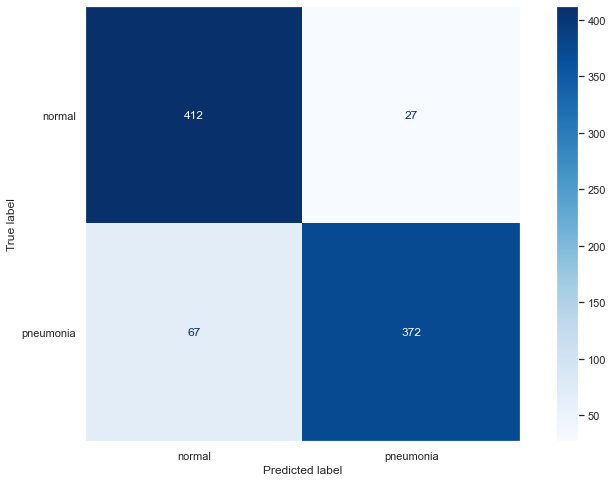

In [221]:
scores(final_model,test_gen, 0.42)

Great! Moving the decision threshold to catch a few more true positives increased our F1 score by a percentage.  It's clear where the sacrifice came where with a decision threshold of 0.5 the model classified normal patients with recall of 96% which has dropped to 94%.  But, this is a necessary sacrifice to make since we increased out total recall of pneumonia patients from 81% to 85% and the overall model accuracy to 89%.

## Next Steps
___

Where this model could improve is reducing those 45 false negatives. These are people who will not receive a pneumonia diagnosis and consequently treatment for their infection due to their misclassification by the model.  The model will need to be further improved with:
* Additional tuning
* Architectural changes
* Additional training images
* Or all of the above

Finally, the model could also be improved with the consultation of a medical professional.  Each convolutional layer in the neural network manipulated to display the feature maps developed during training.  These feature maps highlight the patterns learned while training.  Below I will extract them.

In [9]:
# Get the final model predictions
preds = final_model.predict(test_gen)
preds[preds>=.42]=1
preds[preds<.42]=0

# Find a pneumonia image that the model predicted correctly (last image in val_pneumonia set)
print('Last image in val_pneumonia set was predicted correctly:', preds[-1] == test_gen.labels[-1])

Last image in val_pneumonia set was predicted correctly: [ True]


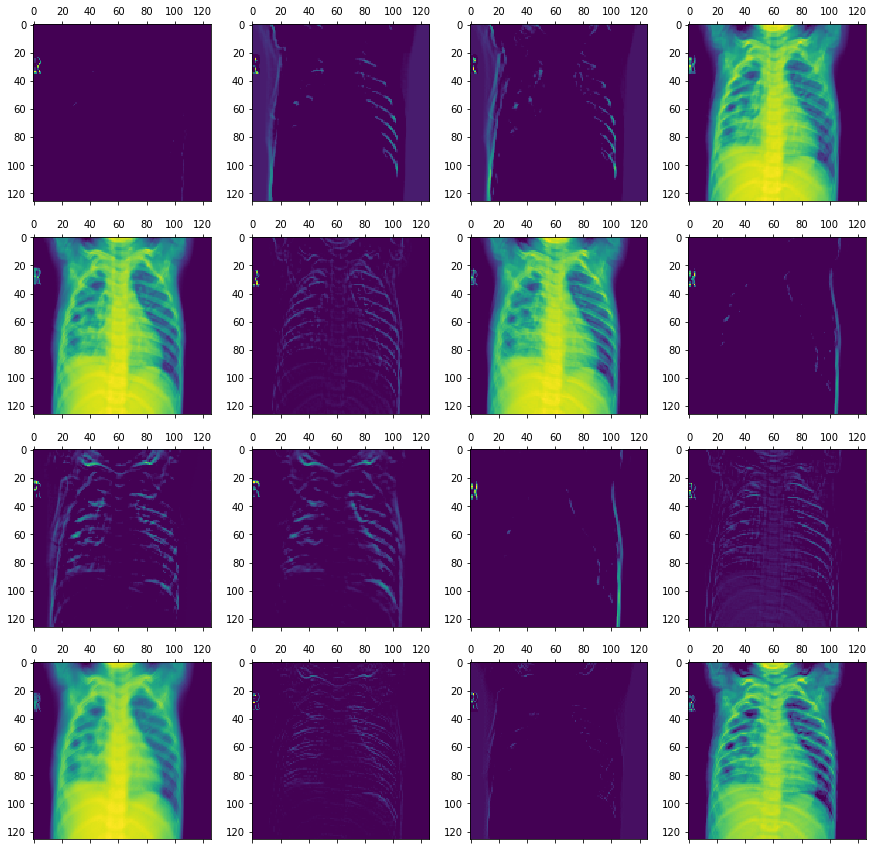

In [13]:
# Import and reshape image for visualization of activation functions
image = PIL.Image.open(f"chest_xray/test/PNEUMONIA/{test_pneum[-1]}")
image = image.resize((128,128))
img_tensor = np.array(image)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = img_tensor/255

# Extract model layer outputs and create model to display feature maps
layer_outputs = [layer.output for layer in final_model.layers[:6]]
activation_model = keras.models.Model(inputs=final_model.input, outputs= layer_outputs)
activations = activation_model.predict(img_tensor)

# Visualize first layer feature map
first_layer_activation = activations[0]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for i in range(16):
    row = (i)//4
    col = (i)%4
    ax = axes[row][col]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

Above is the feature map output from the first conv2d layer of our model.  Since I am not a radiologist, I cannot definitively say whether or not the model is highlighting the features that indicate the presence of pneumonia. But, if shown to a radiologist, they could confirm which of these appears to highlight pneumonia and which are just random noise.  Evaluation with a radiologist would be a great way to improve this model in the future.